# SVM for Heating Load

In [2]:
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


In [3]:
dataframe_all=pd.read_csv('ENB2012.csv')
dataframe_all.Y1 = dataframe_all.Y1.round()
dataframe_all.Y2 = dataframe_all.Y2.round()

x = dataframe_all.iloc[:,:-2].values
#Extracting the outputs for HeatLoad and ColdLoad.
y1_HL=dataframe_all.iloc[:,-2].values.ravel()
y2_CL=dataframe_all.iloc[:,-1].values.ravel()
print("Shape x:  {}     Shape y1_HL: {}  Shape y2_CL: {}".format(x.shape, y1_HL.shape,y2_CL.shape)) 


Shape x:  (768, 8)     Shape y1_HL: (768,)  Shape y2_CL: (768,)


## Scaling

In [161]:
# 25% for Test Size  -  Seed=0 For debugging.
X_train, X_test, y_train, y_test = train_test_split(x, y1_HL,random_state=0)

#Normalization
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)


## Grid Search

In [26]:
#Find C and gamma
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = [{'gamma':gamma_range, 'C':C_range}]
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
[{'gamma': array([  1.00000000e-09,   1.00000000e-08,   1.00000000e-07,
         1.00000000e-06,   1.00000000e-05,   1.00000000e-04,
         1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02,
         1.00000000e+03]), 'C': array([  1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
         1.00000000e+01,   1.00000000e+02,   1.00000000e+03,
         1.00000000e+04,   1.00000000e+05,   1.00000000e+06,
         1.00000000e+07,   1.00000000e+08,   1.00000000e+09,
         1.00000000e+10])}]


In [17]:
grid_search = GridSearchCV(SVC(
                                              
                        random_state=0,
                        ) 
                           , param_grid, cv=kfold, scoring='neg_mean_squared_error')

grid_search.fit(X_train_scaled, y_train)
    #list_best_parameters.append(grid_search.best_params_)
    #list_test_score.append(grid_search.score(X_test_scaled, y_test))
    #list_CV_score.append(grid_search.best_score_)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))


Best parameters: {'C': 10000.0, 'gamma': 0.10000000000000001}
Best cross-validation score: -1.32
Test set score: -0.71


In [86]:
results = pd.DataFrame(grid_search.cv_results_)
scores = grid_search.cv_results_['mean_test_score'].reshape(len(param_grid[0]['C']), len(param_grid[0]['gamma']))


(13, 13)

## Hyperparameter Heatmap

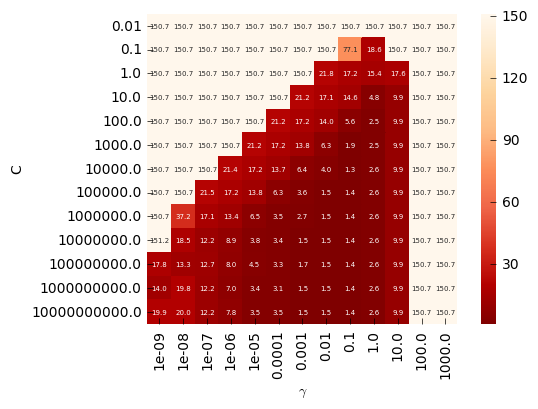

In [226]:
import seaborn as sns
ax = sns.heatmap(
    np.abs(scores),
    cmap="OrRd_r",
    cbar=True,
    annot=True,
    square=True,
    fmt='.1f',
    yticklabels=(param_grid[0]['C']),
    xticklabels=(param_grid[0]['gamma']),
    annot_kws={'size': 5})
plt.xlabel('$\gamma$')
plt.ylabel('C')
plt.savefig("./plots/SVM/Y1/heatmap_Y1HL.png", dpi=300, bbox_inches='tight') # save as png
plt.show()
sns.reset_orig()


# Validation Curve

PLOT the training and validation error as a function of σ or p (regularization
graph) and report the optimal value of your regularization parameter.

C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


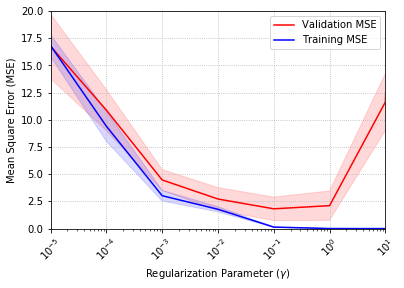

In [17]:
from sklearn.learning_curve import validation_curve
param_range = gamma_range
train_scores, test_scores = validation_curve(
                                                estimator=SVC(     C=10000.0,                                 
                                                                    random_state=0,
                                                                    ) ,
                                                X=X_train_scaled,
                                                y=y_train,
                                                param_name="gamma",
                                                param_range=param_range,
                                                scoring='neg_mean_squared_error',
                                                cv=5)
train_scores = np.abs(train_scores)
test_scores = np.abs(test_scores)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, test_mean,
    color='red',    
    label='Validation MSE')
plt.fill_between(param_range,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='red')
plt.plot(param_range, train_mean,
    color='blue',   
    label='Training MSE')
plt.fill_between(param_range, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.grid(linestyle='dotted')
plt.xticks(rotation=45)
plt.xscale('log')
plt.legend(loc='upper right', fontsize =10)
plt.xlabel("Regularization Parameter ($\gamma$)")
plt.ylabel('Mean Square Error (MSE)')
plt.xlim([1e-5, 10])
plt.ylim([0, 20])
plt.savefig("./plots/SVM/Y1/validation_curve_Y1HL.png", dpi=300, bbox_inches='tight') # save as png
plt.show()

# Final Model

In [6]:
MSE_test_list =[]
MSE_train_list =[]
MSE_val_list=[]

#Run for 20 times.
for i in range(1,21):
    X_train, X_test, y_train, y_test = train_test_split(x, y1_HL)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    kfold = KFold(n_splits=5, shuffle=True)
    
    svc = SVC(C=10000.0, gamma=0.1)
    scores = cross_validate(svc, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kfold, return_train_score=True)
    
    MSE_val_list.append(np.mean(np.abs(scores['test_score'])))
    MSE_train_list.append(np.mean(np.abs(scores['train_score'])))
    
    svc.fit(X_train_scaled, y_train)
    y_pred_test = svc.predict(X_test_scaled)

    MSE_test=mean_squared_error(y_test, y_pred_test)
    MSE_test_list.append(MSE_test)

    
print("Test Set MSE:               {:.2f}±{:.2f}".format(np.mean(MSE_test_list),np.std(MSE_test_list)))
print("Train Set MSE:              {:.2f}±{:.2f}".format(np.mean(MSE_train_list),np.std(MSE_train_list)))
print("Validation Set MSE:         {:.2f}±{:.2f}".format(np.mean(MSE_val_list),np.std(MSE_val_list)))


Test Set MSE:               1.20±0.71
Train Set MSE:              0.14±0.02
Validation Set MSE:         1.78±0.43


# Metrics

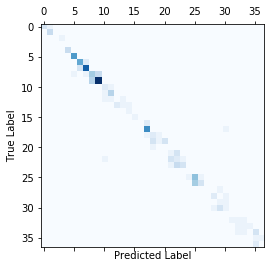

In [34]:
from sklearn.metrics import confusion_matrix
conf_mx=confusion_matrix(y_test, y_pred_test)
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel('True Label')
plt.savefig("./plots/SVM/Y1/confusion_matrix_Y1HL.png", dpi=300, bbox_inches='tight') # save as png
plt.show()

In [35]:
from sklearn.metrics import classification_report
target_names = np.unique(y_test).astype(int).astype(np.str)
print(classification_report(y_test, y_pred_test, target_names=None))

             precision    recall  f1-score   support

        6.0       1.00      0.75      0.86         4
        7.0       0.80      1.00      0.89         4
        8.0       0.00      0.00      0.00         1
        9.0       0.00      0.00      0.00         0
       10.0       1.00      1.00      1.00         4
       11.0       0.91      1.00      0.95        10
       12.0       0.75      0.82      0.78        11
       13.0       0.82      0.82      0.82        17
       14.0       0.55      0.50      0.52        12
       15.0       0.81      0.77      0.79        22
       16.0       0.40      0.67      0.50         3
       17.0       0.71      0.83      0.77         6
       18.0       0.00      0.00      0.00         3
       19.0       0.50      0.25      0.33         4
       20.0       0.50      1.00      0.67         1
       21.0       1.00      1.00      1.00         1
       23.0       0.00      0.00      0.00         2
       24.0       0.79      0.92      0.85   

C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
